In [23]:
import tensorflow as tf
from tensorflow_examples.models.pix2pix import pix2pix

import tensorflow_datasets as tfds

from IPython.display import clear_output
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np
import time

import os

In [59]:
trainIm_path = 'D:/DDSM_Segmentation/Train_Images/'
trainLabel_path = 'D:/DDSM_Segmentation/Train_Labels_Pec/'
testIm_path = 'D:/DDSM_Segmentation/Test_Images/'
testLabel_path = 'D:/DDSM_Segmentation/Test_Labels_Pec/'

In [60]:
for file in os.listdir(trainIm_path):
    im, mask = Image.open(trainIm_path+file), Image.open(trainLabel_path+file)
    im = np.array(im.convert('RGB'))
    im = im/255.0
    mask = np.array(mask.convert('L'))
    mask = np.resize(mask, (224,224,1))
    mask = mask/255.0
    temp_dataset = tf.data.Dataset.from_tensors((im, mask))
    try: 
        train = tf.data.Dataset.concatenate(train, temp_dataset)
    except:
        train = tf.data.Dataset.from_tensors((im, mask))
        
for file in os.listdir(testIm_path):
    im, mask = Image.open(testIm_path+file), Image.open(testLabel_path+file)
    im = np.array(im.convert('RGB'))
    im = im/255.0
    mask = np.array(mask.convert('L'))
    mask = np.resize(mask, (224,224,1))
    mask = mask/255.0
    temp_dataset = tf.data.Dataset.from_tensors((im, mask))
    try: 
        test = tf.data.Dataset.concatenate(test, temp_dataset)
    except:
        test = tf.data.Dataset.from_tensors((im, mask))

In [61]:
TRAIN_LENGTH = len(os.listdir('D:/DDSM_Segmentation/Train_Images/'))
BATCH_SIZE = 64
BUFFER_SIZE = 1000
STEPS_PER_EPOCH = TRAIN_LENGTH // BATCH_SIZE

In [62]:
train_dataset = train.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()
train_dataset = train_dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
test_dataset = test.batch(BATCH_SIZE)

In [6]:
train_dataset

<PrefetchDataset shapes: ((None, 224, 224, 3), (None, 224, 224, 1)), types: (tf.float64, tf.float64)>

In [7]:
def display(display_list):
    plt.figure(figsize=(15, 15))

    title = ['Input Image', 'True Mask', 'Predicted Mask']

    for i in range(len(display_list)):
        plt.subplot(1, len(display_list), i+1)
        plt.title(title[i])
        plt.imshow(tf.keras.preprocessing.image.array_to_img(display_list[i]))
        plt.axis('off')
    plt.show()

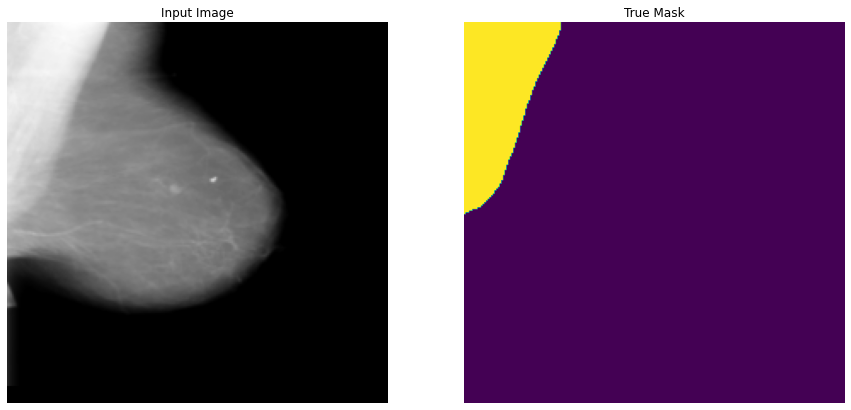

In [57]:
for image, mask in test.take(3):
    sample_image, sample_mask = image, mask
display([sample_image, sample_mask])

In [9]:
OUTPUT_CHANNELS = 3
base_model = tf.keras.applications.MobileNetV2(input_shape=[224, 224, 3], include_top=False)
# Use the activations of these layers
layer_names = [
    'block_1_expand_relu',   # 64x64
    'block_3_expand_relu',   # 32x32
    'block_6_expand_relu',   # 16x16
    'block_13_expand_relu',  # 8x8
    'block_16_project',      # 4x4
]
layers = [base_model.get_layer(name).output for name in layer_names]

# Create the feature extraction model
down_stack = tf.keras.Model(inputs=base_model.input, outputs=layers)

down_stack.trainable = False

In [10]:
up_stack = [
    pix2pix.upsample(512, 3),  # 4x4 -> 8x8
    pix2pix.upsample(256, 3),  # 8x8 -> 16x16
    pix2pix.upsample(128, 3),  # 16x16 -> 32x32
    pix2pix.upsample(64, 3),   # 32x32 -> 64x64
]

In [11]:
def unet_model(output_channels):
    inputs = tf.keras.layers.Input(shape=[224, 224, 3])
    x = inputs

    # Downsampling through the model
    skips = down_stack(x)
    x = skips[-1]
    skips = reversed(skips[:-1])

    # Upsampling and establishing the skip connections
    for up, skip in zip(up_stack, skips):
        x = up(x)
        concat = tf.keras.layers.Concatenate()
        x = concat([x, skip])

    # This is the last layer of the model
    last = tf.keras.layers.Conv2DTranspose(
      output_channels, 3, strides=2,
      padding='same')  #64x64 -> 128x128

    x = last(x)

    return tf.keras.Model(inputs=inputs, outputs=x)

In [12]:
model = unet_model(OUTPUT_CHANNELS)
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [13]:
model.summary()

Model: "functional_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
functional_1 (Functional)       [(None, 112, 112, 96 1841984     input_2[0][0]                    
__________________________________________________________________________________________________
sequential (Sequential)         (None, 14, 14, 512)  1476608     functional_1[0][4]               
__________________________________________________________________________________________________
concatenate (Concatenate)       (None, 14, 14, 1088) 0           sequential[0][0]                 
                                                                 functional_1[0][3]    

In [14]:
def create_mask(pred_mask):
    pred_mask = tf.argmax(pred_mask, axis=-1)
    pred_mask = pred_mask[..., tf.newaxis]
    return pred_mask[0]

In [15]:
def show_predictions(dataset=None, num=1):
    if dataset:
        for image, mask in dataset.take(num):
            pred_mask = model.predict(image)
            display([image[0], mask[0], create_mask(pred_mask)])
    else:
        display([sample_image, sample_mask,
            create_mask(model.predict(sample_image[tf.newaxis, ...]))])

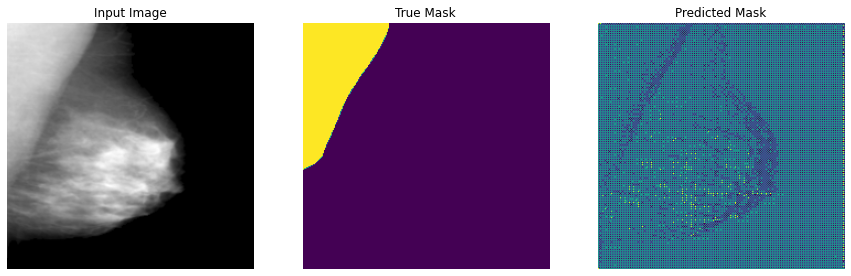

In [16]:
show_predictions()

In [17]:
class DisplayCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        clear_output(wait=True)
        show_predictions()
        print ('\nSample Prediction after epoch {}\n'.format(epoch+1))

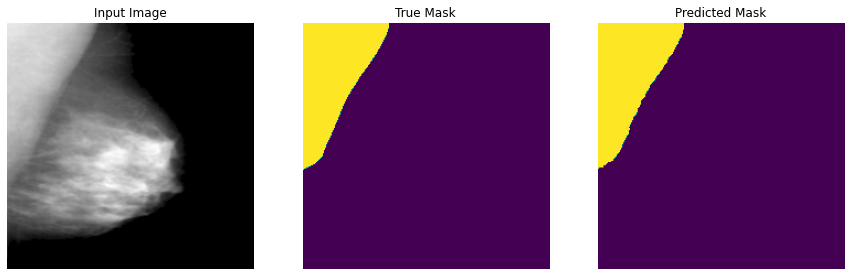


Sample Prediction after epoch 20

20/20 [==============================] - 103s 5s/step - loss: 0.0294 - accuracy: 0.9896 - val_loss: 0.0492 - val_accuracy: 0.9859


In [18]:
EPOCHS = 20
VAL_SUBSPLITS = 5
VALIDATION_STEPS = len(os.listdir('D:/DDSM_Segmentation/Test_Images/'))//BATCH_SIZE//VAL_SUBSPLITS

model_history = model.fit(train_dataset, epochs=EPOCHS,
                          steps_per_epoch=STEPS_PER_EPOCH,
                          validation_steps=VALIDATION_STEPS,
                          validation_data=test_dataset,
                          callbacks=[DisplayCallback()])

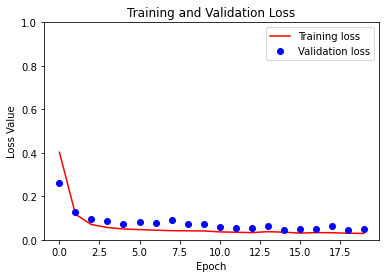

In [19]:
loss = model_history.history['loss']
val_loss = model_history.history['val_loss']

epochs = range(EPOCHS)

plt.figure()
plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'bo', label='Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss Value')
plt.ylim([0, 1])
plt.legend()
plt.show()

In [45]:
model.save('PecModelv1.h5')

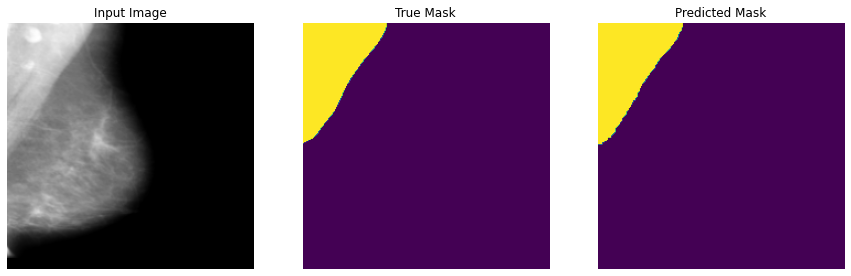

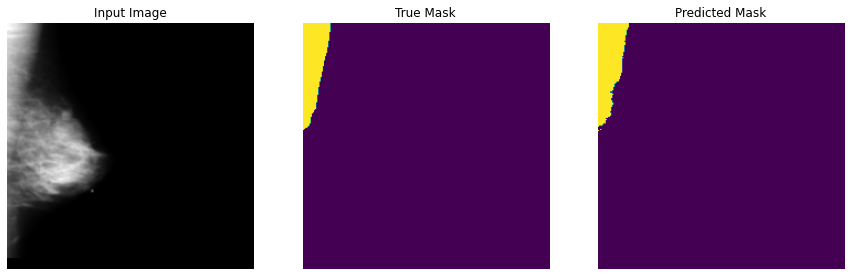

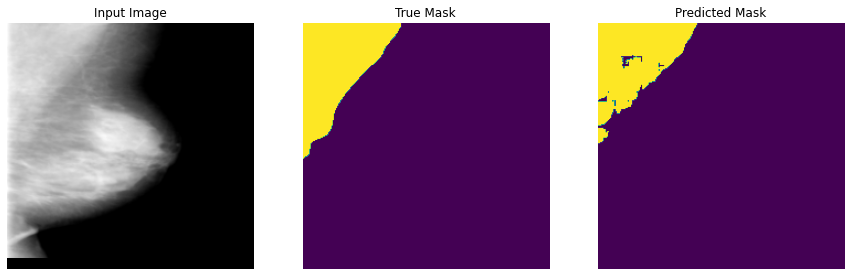

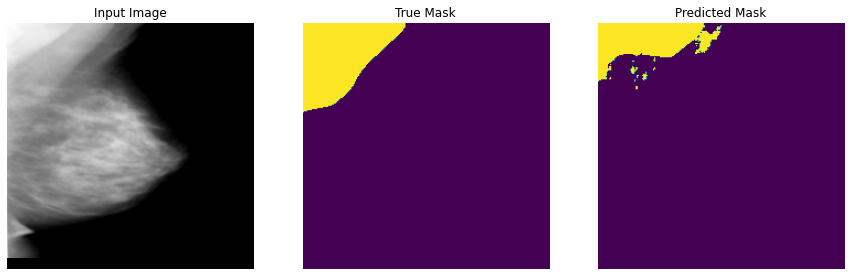

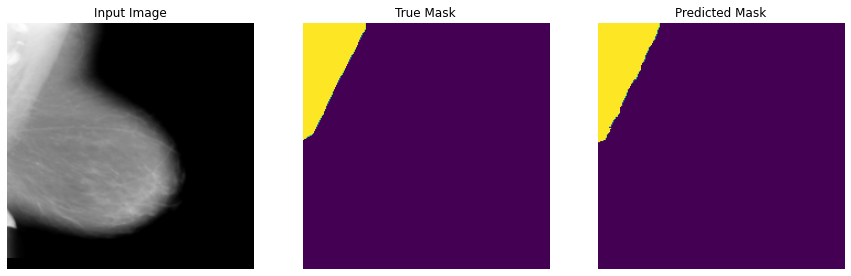

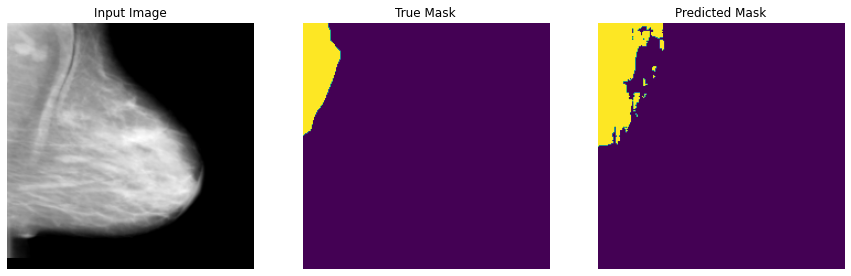

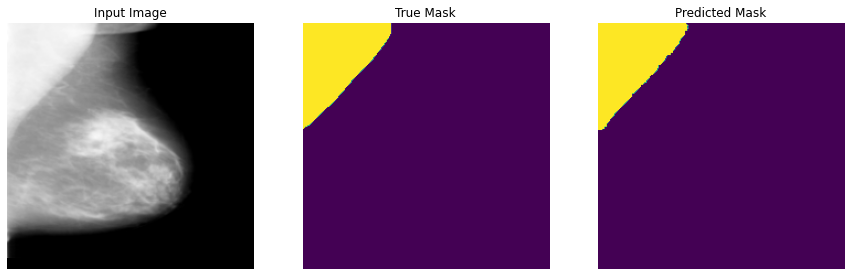

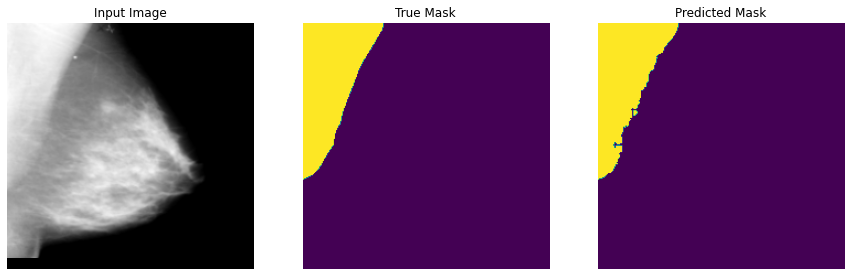

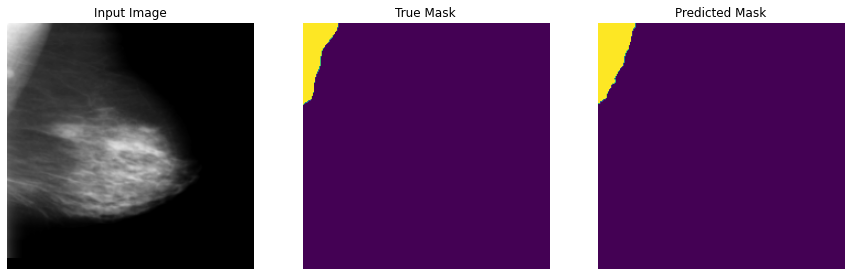

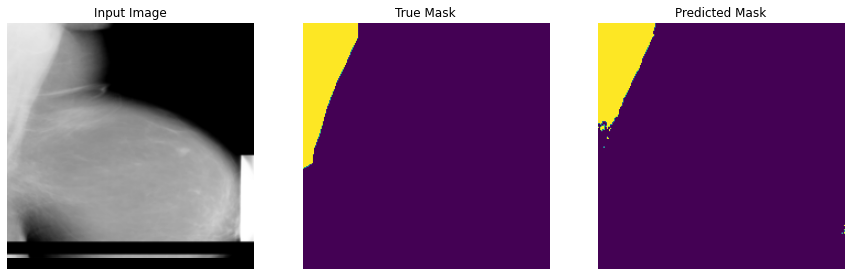

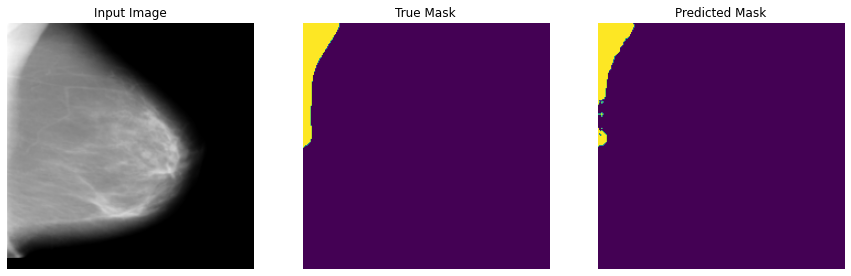

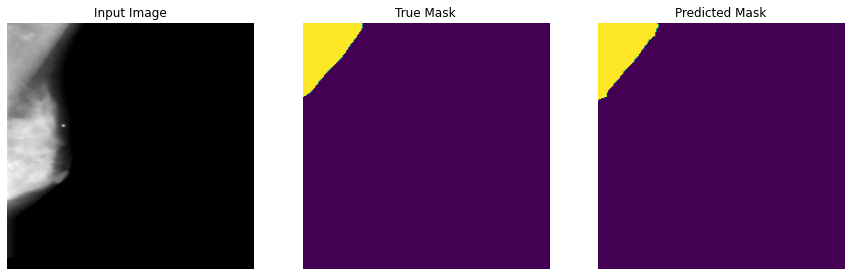

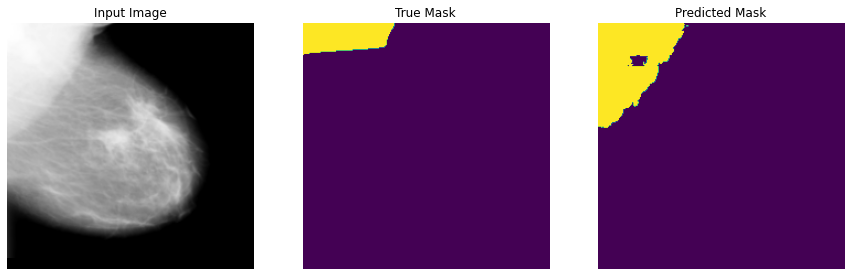

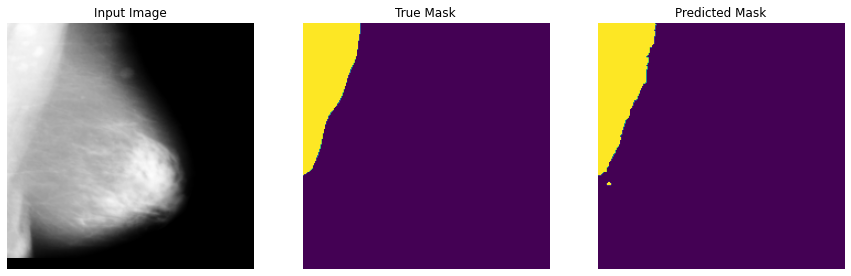

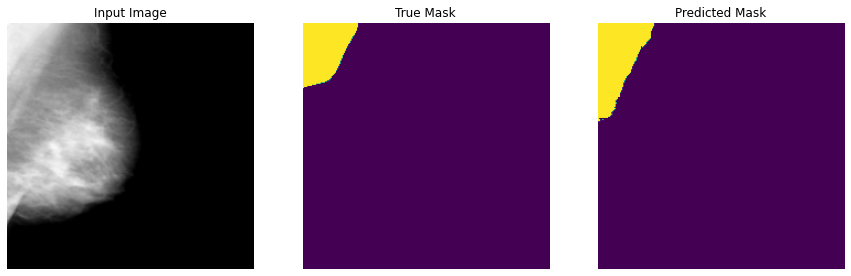

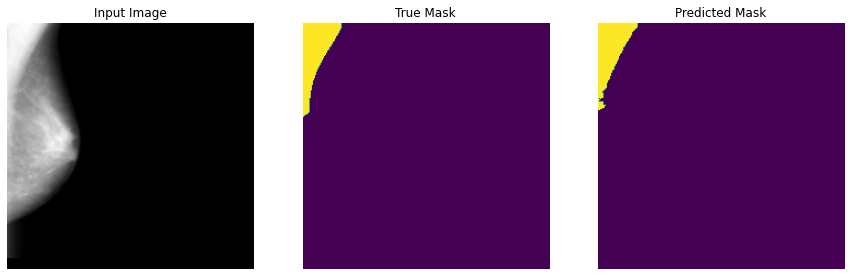

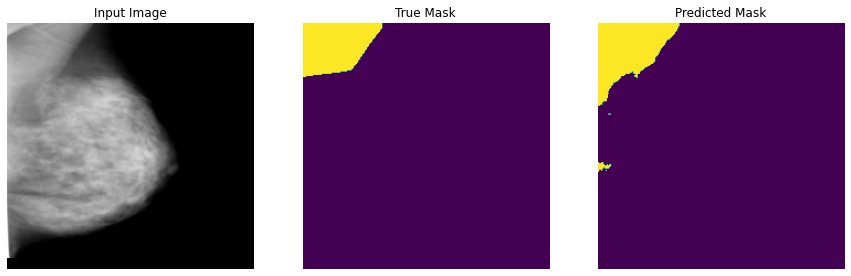

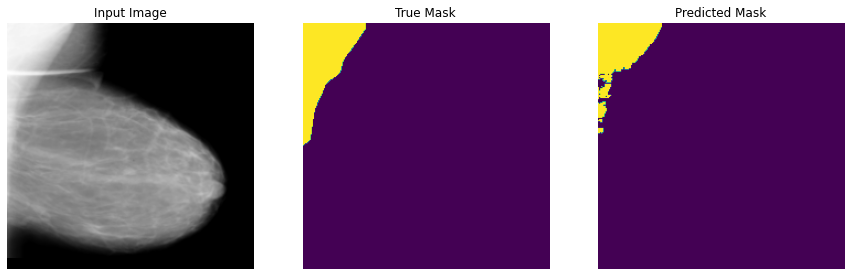

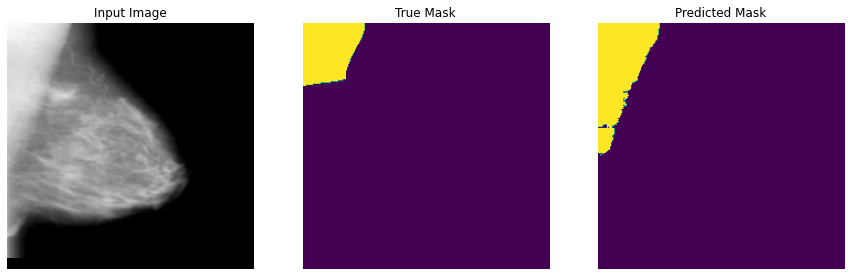

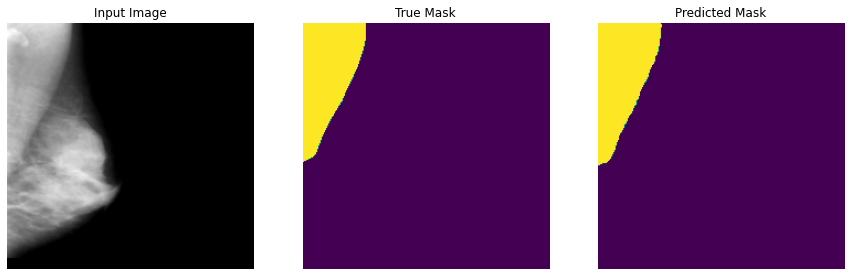

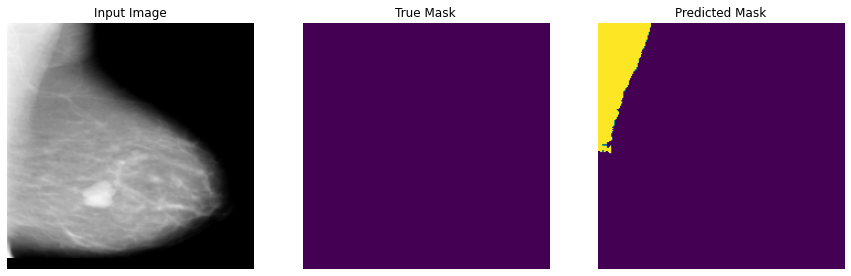

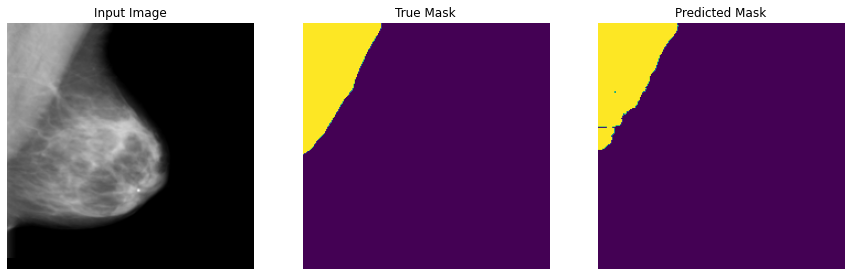

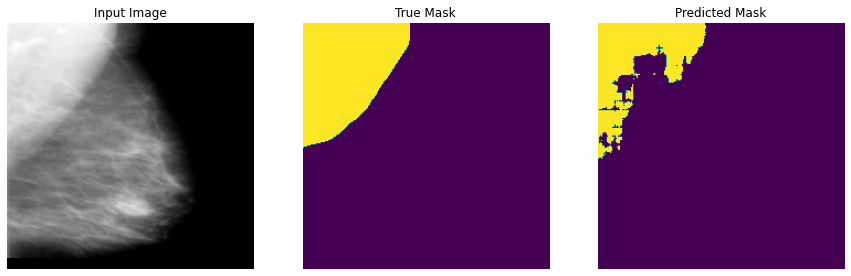

In [65]:
test_dataset = test.batch(30)
show_predictions(test_dataset, 30)